**PARSING AND DERIVING CLOUD MASKS & MULTISPECTRAL DATA FROM GOES-16,17 DATA IN .nc FORMAT**

In [2]:
import tifffile as tff
from timeit import default_timer as timer 
import pvlib
from tqdm import tqdm
from PIL import Image
import numpy as np
import gc
import os
import patoolib
import warnings
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random
import pyproj
from pyproj import Transformer
from rasterio.warp import reproject, transform_bounds, Resampling
import rasterio
from rasterio.transform import from_origin
from skimage.transform import resize as interp_resize
import h5py
import pygrib
import netCDF4
from netCDF4 import Dataset
%matplotlib inline
warnings.filterwarnings("ignore")

**UNARCHIEVE ALL DATA FROM THIS REPO: SNOW MAP, ASTER GDEM & LON, LAT OF GOES-16,17;**
**AFTER THAT SELECT NEEDED SATELLITE: GOES_16 or GOES_17 (GOES_16_mode or GOES_17_mode)**


In [7]:
#unrar ar archieved data
your_current_dir = os.getcwd()
print('Your current dir of this .ipynb file',your_current_dir)
GOES_16_mode = True
GOES_17_mode = False
for name in os.listdir(your_current_dir):
    if name.endswith('.rar'):
        try:
            patoolib.extract_archive(your_current_dir+'/'+name, outdir=your_current_dir+'/')
            clear_output()
        except:
            print('YOU ALREADY UNARCHIEVED THIS DATA')
if GOES_16_mode:       
    for name in os.listdir(your_current_dir+'/GOES_16'):
        if name.endswith('.rar'):
            try:
                patoolib.extract_archive(your_current_dir+'/GOES_16/'+name, outdir=your_current_dir+'/GOES_16/')
                clear_output()
            except:
                print('YOU ALREADY UNARCHIEVED THIS DATA')
if GOES_17_mode:
    for name in os.listdir(your_current_dir+'/GOES_17'):
        if name.endswith('.rar'):
            try:
                patoolib.extract_archive(your_current_dir+'/GOES_17/'+name, outdir=your_current_dir+'/GOES_17/')
                clear_output()
            except:
                print('YOU ALREADY UNARCHIEVED THIS DATA')


**THIS FUNCTION MAKES A HORIZONTAL & VERTICAL SHIFT OF IMAGE - MAYBE USEFULL TO CORRECT MASKS OR DEM AFTER REPROJECTION**

In [8]:
def shift_image(X, dx, dy):
    X = np.roll(X, dy, axis=0)
    X = np.roll(X, dx, axis=1)
    if dy>0:
        X[:dy, :] = 0
    elif dy<0:
        X[dy:, :] = 0
    if dx>0:
        X[:, :dx] = 0
    elif dx<0:
        X[:, dx:] = 0
    return X

**NEXT YOU SHOULD DOWNLOAD CLEAR_SKY AND CLOUD_MOISTURE L2 PRODUCT OF GOES-R FROM HERE: http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi**

- You should choose 'FULL DISK' format
- Download multispectral data (ABI L2 Cloud & Moisture Imagery) in multiband format - it's easier to parse
- Cloud masks is the ABI L2 Clear Sky Mask product

**PARSEING GOES-16 DATA: CLOUD MASKS (CLEAR SKY) AT FIRST**

255
[  0 255] 13617988.0 62897.576470588414


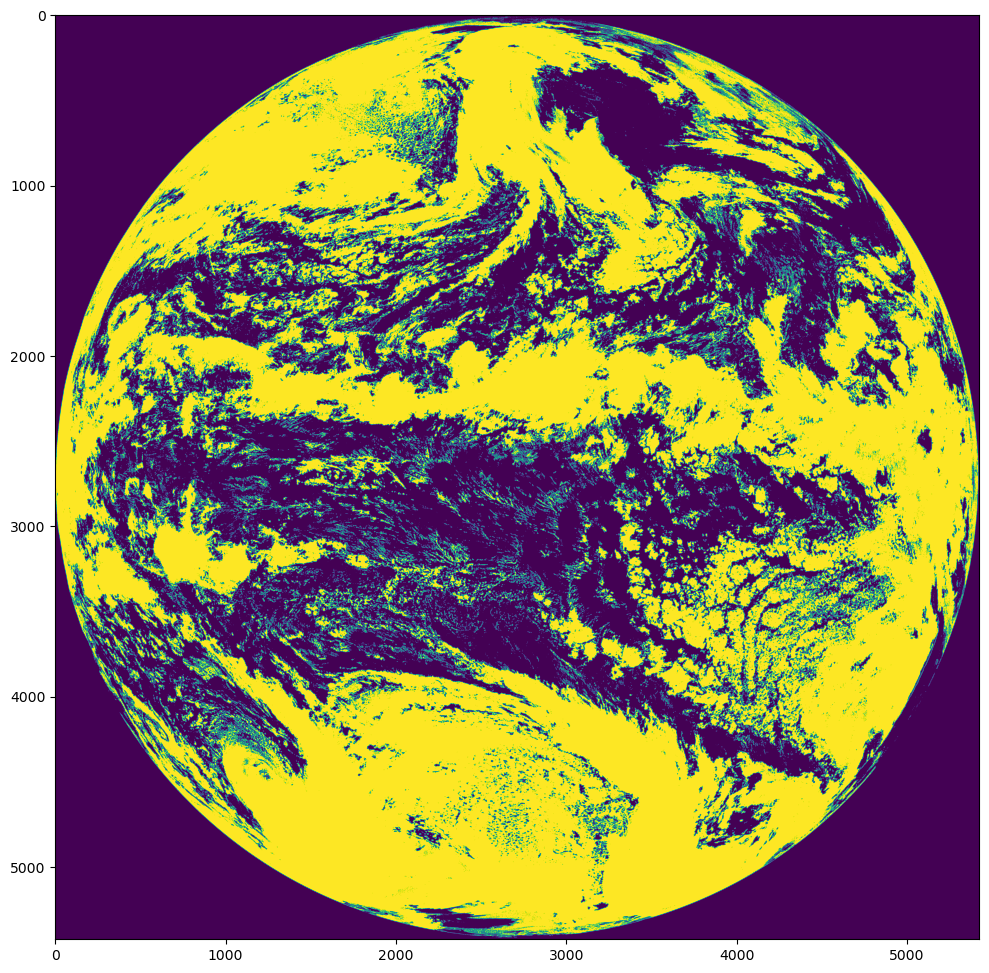

In [202]:
# Download files at this link: http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi
if GOES_16_mode:       
    for name in os.listdir(your_current_dir+'/GOES_16'):
        clear_sky_path = your_current_dir+'/GOES_16/'+name
if GOES_17_mode:       
    for name in os.listdir(your_current_dir+'/GOES_17'):
        clear_sky_path = your_current_dir+'/GOES_17/'+name
file = Dataset(clear_sky_path)
ACM = np.array(file.variables['ACM'])
BCM = np.array(file.variables['BCM'])
DQF = np.array(file.variables['DQF'])
x_image = np.array(file.variables['x_image'])
y_image = np.array(file.variables['y_image'])
# Get the pixel values
data_vars = file.variables
cloud_probs = np.array(file.variables['Cloud_Probabilities'])
cloud_probs[cloud_probs==65535]=0
cloud_probs = cloud_probs/np.max(cloud_probs)
cloud_probs_thr = cloud_probs.copy()
cloud_probs_thr[cloud_probs_thr>=0.98]=255
cloud_probs_thr[cloud_probs_thr<0.98]=0
DQF_unint = DQF.copy()
DQF_unint[DQF_unint==0]=1
DQF_unint[DQF_unint!=1]=0
cloud_probs_thr = (cloud_probs_thr*DQF_unint).astype(np.uint8)
plt.figure(figsize=(12,12))
# Plot the image
cloud_0 = ACM.copy()
print(cloud_0[0,0])
cloud_0[cloud_0==255] = 0
cloud_0[cloud_0==0] = 255
cloud_0[cloud_0!=255]=0
cloud_0 = np.abs(cloud_0-255).astype(np.uint8)
print(np.unique(cloud_probs_thr), np.sum(cloud_probs_thr/255), np.sum(cloud_0/255))
tff.imwrite(clear_sky_path.replace('.nc', '.jpg'),cloud_probs_thr)
plt.imshow(cloud_probs_thr)
#----------------------------------------------------------------------------------------------------------- 
# Show the image
plt.show()

**NEXT PROCESS GOES MULTISPECTRAL DATA FROM L2 CLOUD_MOISTURE PRODUCT**

402.29138
max and min rad of 1st channel: 1.278094 0.0
np.max(BT4) 402.29138
1.0 1.0 1.0 1.0 1.0 1.0


<Figure size 1200x1200 with 0 Axes>

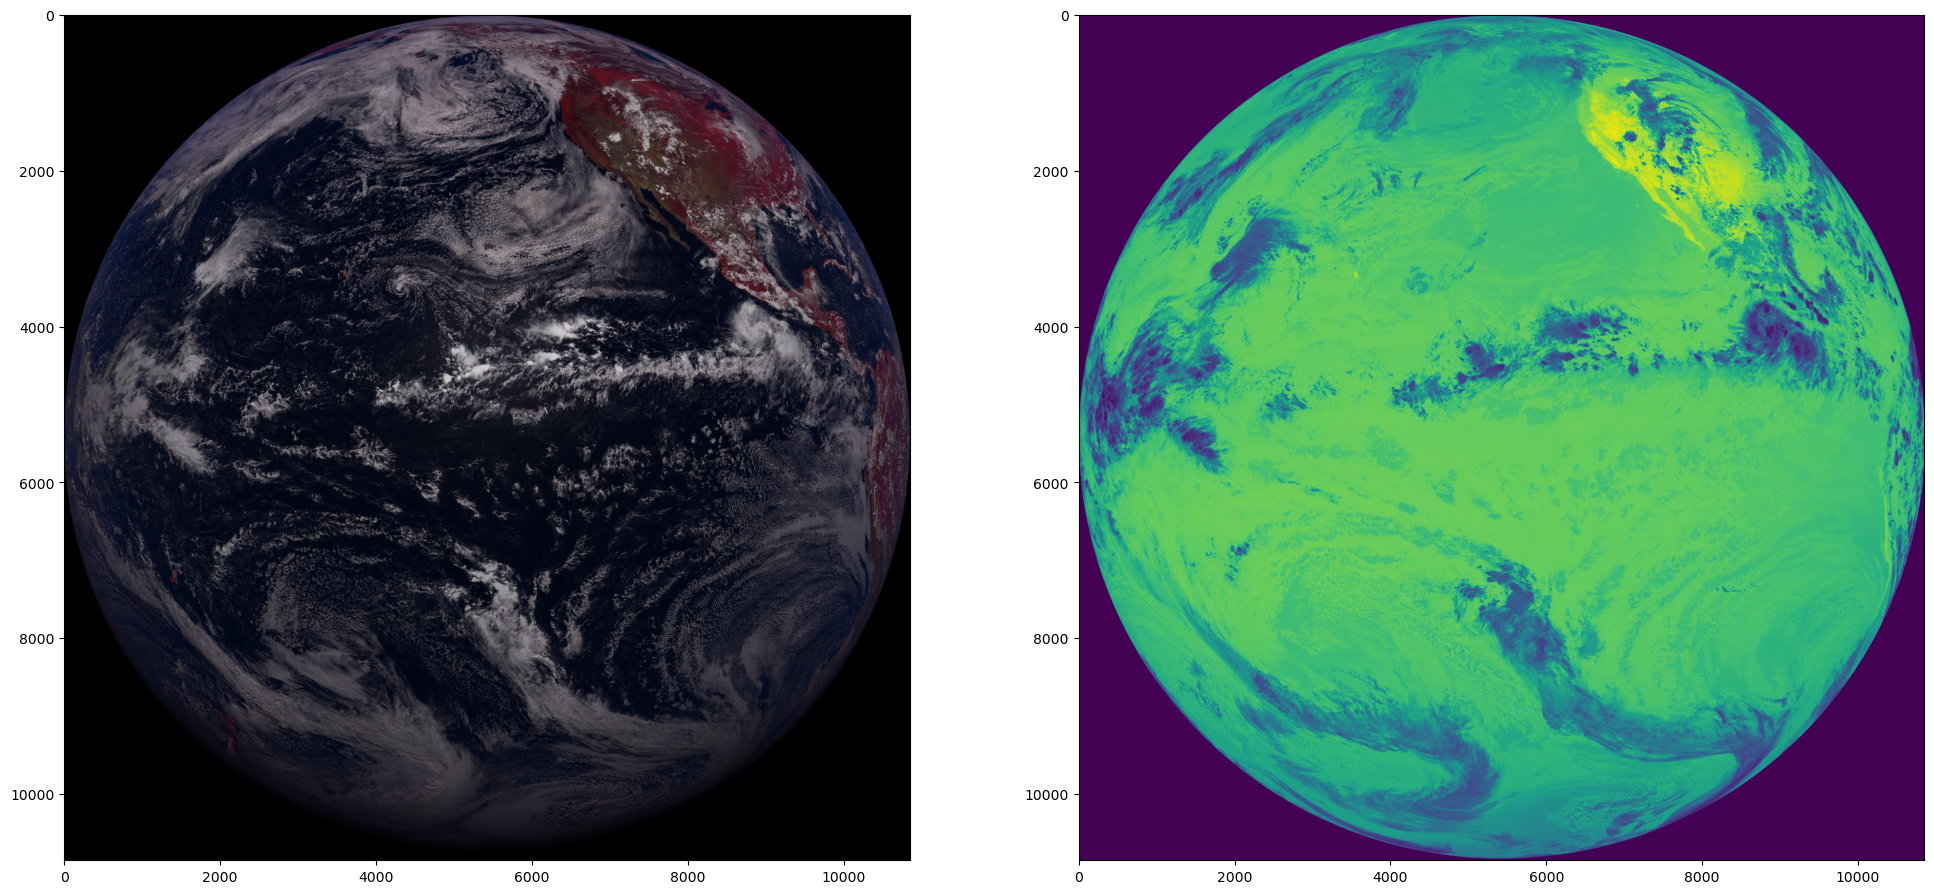

In [169]:
from netCDF4 import Dataset 
fil = Dataset(r"H:/GOES-17/2022/july/15/2100/OR.nc")
data_vars = fil.variables
b,g,r = np.array(fil.variables['CMI_C01']), np.array(fil.variables['CMI_C02']),np.array(fil.variables['CMI_C03'])
BT4 = np.array(fil.variables['CMI_C07'])
BT5 = np.array(fil.variables['CMI_C08'])
BT6 = np.array(fil.variables['CMI_C09'])
BT7 = np.array(fil.variables['CMI_C11'])
BT8 = np.array(fil.variables['CMI_C13'])
BT9 = np.array(fil.variables['CMI_C14'])
# fill borders with zeros
BT4[BT4==BT4[0,0]]=0
BT5[BT5==BT5[0,0]]=0
BT6[BT6==BT6[0,0]]=0
BT7[BT7==BT7[0,0]]=0
BT8[BT8==BT8[0,0]]=0
BT9[BT9==BT9[0,0]]=0
min_BT4,min_BT5,min_BT6,min_BT7,min_BT8,min_BT9 =np.unique(BT4)[1],np.unique(BT5)[1],np.unique(BT6)[1],np.unique(BT7)[1],np.unique(BT8)[1],np.unique(BT9)[1]
r_min, g_min, b_min = 0,0,0 # np.min(r),np.min(g),np.min(b)
print(np.max(BT4))
b_border = b[0,0]
g_border = g[0,0]
r_border = r[0,0]
b[b==b_border]=0
g[g==g_border]=0
r[r==r_border]=0
print('max and min rad of 1st channel:',np.max(b), np.min(b))
plt.figure(figsize=(12,12))
y_image = np.array(fil.variables['y_image'])
x_image = np.array(fil.variables['x_image'])
y_image_bounds = np.array(fil.variables['y_image_bounds'])
x_image_bounds = np.array(fil.variables['x_image_bounds'])
geospatial_lat_lon_extent = np.array(fil.variables['geospatial_lat_lon_extent'])
goes_imager_projection = fil.variables['goes_imager_projection']
nominal_satellite_height = fil.variables['nominal_satellite_height']
r_normed = (r - r_min)/(np.max(r)-r_min)
g_normed = (g - g_min)/(np.max(g)-g_min)
b_normed = (b - b_min)/(np.max(b)-b_min)
b_border = b_normed[0,0]
g_border = g_normed[0,0]
r_border = r_normed[0,0]
b_normed[b_normed==b_border]=0
g_normed[g_normed==g_border]=0
r_normed[r_normed==r_border]=0
r_normed = interp_resize(r_normed, (10848,10848))
g_normed = interp_resize(g_normed, (10848,10848))
b_normed = interp_resize(b_normed, (10848,10848))
rgb = np.dstack([r_normed,g_normed,b_normed])
rgb = (rgb*255.).astype(np.uint8)
print('np.max(BT4)',np.max(BT4))
BT4 = (BT4-min_BT4)/(np.max(BT4)-min_BT4)
BT5 = (BT5-min_BT5)/(np.max(BT5)-min_BT5)
BT6 = (BT6-min_BT6)/(np.max(BT6)-min_BT6)
BT7 = (BT7-min_BT7)/(np.max(BT7)-min_BT7)
BT8 = (BT8-min_BT8)/(np.max(BT8)-min_BT8)
BT9 = (BT9-min_BT9)/(np.max(BT9)-min_BT9)
print(np.max(BT4),np.max(BT5),np.max(BT6),np.max(BT7),np.max(BT8),np.max(BT9))
BT4 = np.clip(BT4, 0,1)
BT5 = np.clip(BT5, 0,1)
BT6 = np.clip(BT6, 0,1)
BT7 = np.clip(BT7, 0,1)
BT8 = np.clip(BT8, 0,1)
BT9 = np.clip(BT9, 0,1)
BT4 = interp_resize(BT4, (10848,10848))
BT5 = interp_resize(BT5, (10848,10848))
BT6 = interp_resize(BT6, (10848,10848))
BT7 = interp_resize(BT7, (10848,10848))
BT8 = interp_resize(BT8, (10848,10848))
BT9 = interp_resize(BT9, (10848,10848))
BT = np.dstack([BT4, BT5, BT6, BT7, BT8, BT9])
tff.imsave(r'H:/GOES-17/2022/july/15/2100/BT_normed_2100.tif',BT)
tff.imsave(r'H:/GOES-17/2022/july/15/2100/rgb_raw_2100.tif',rgb)
fig, ax = plt.subplots(1,2, figsize=(24,12))
ax[0].imshow(rgb)
ax[1].imshow(BT8)
plt.show()
# clear memory
r,g,b,rgb,r_normed,g_normed,b_normed = None,None,None,None,None,None,None
BT,BT4,BT5,BT6,BT7,BT8,BT9 = None,None,None,None,None,None,None

**APPLY ZENITH SOLAR CORRECTION FOR IMAGE**

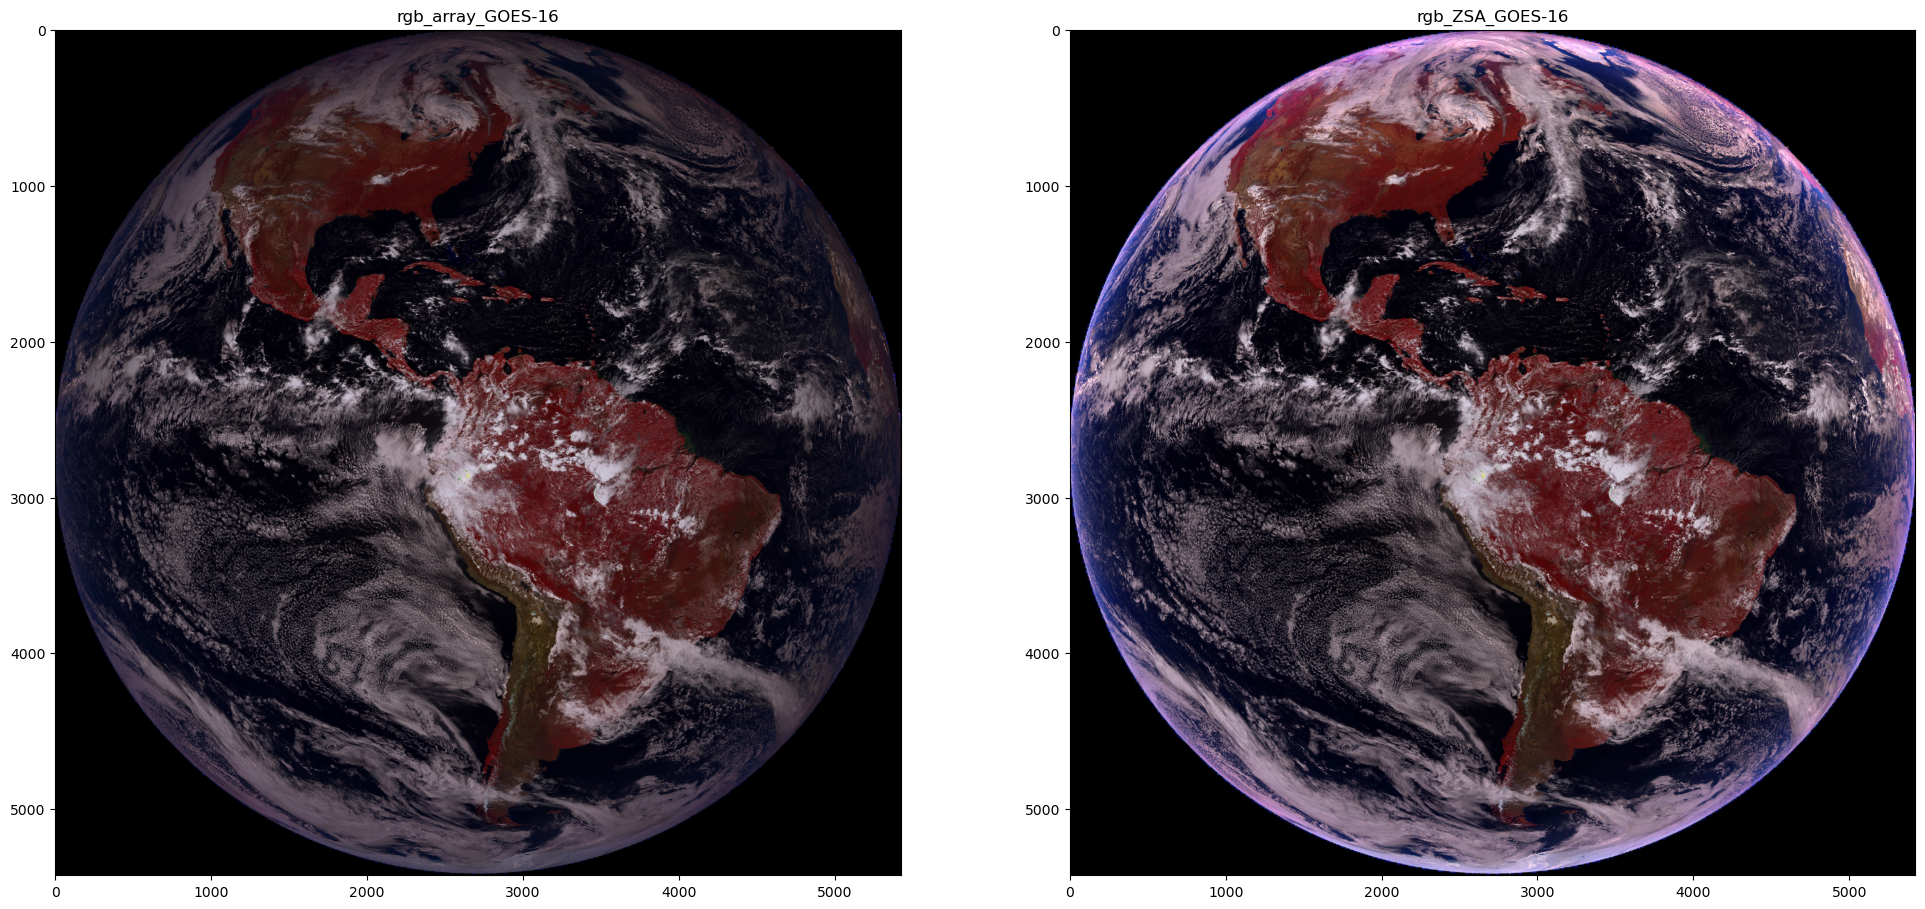

634.5620268000057

In [236]:
def ZSA_for_full_image(rgb_array,lats, lons, time=pd.Timestamp('2022-10-15 17:00:00'), sat_lon = -137.0):
    # Define the longitude and latitude ranges
    rgb_shape = rgb_array.shape[0]
    out_file = r'H:/GOES-16/2022/october/15/1700/rgb_ZSA.jpg'
    # Define the location
    # create a Location object with the specified coordinates
    location = pvlib.location.Location(lats.flatten(), lons.flatten())
    times = np.array([time for i in range(len(lons.flatten()))])
    # calculate the solar position for the specified time and location
    solar_position = location.get_solarposition(times)
    # calculate the zenith angle for each pixel
    zenith_angle = solar_position['apparent_zenith'].values
    zenith_angle = np.clip(zenith_angle, 0.0, 80.0) # clip to avoid angles close to 90 and division by zero!
    zenith_angle_rad = np.deg2rad(zenith_angle)
    # Calculate the cosine of the zenith angle for all pixels
    cos_zenith_angle = np.cos(zenith_angle_rad)
    cos_zenith_angles = cos_zenith_angle.reshape(rgb_shape,rgb_shape)
    # Apply the correction to the satellite image
    corrected_sat_image = rgb_array / cos_zenith_angles[:, :, np.newaxis]
    corrected_sat_image = np.clip(corrected_sat_image, 0, 255).astype(np.uint8)
    Image.fromarray(corrected_sat_image).save(out_file)
    cos_zenith_angles_path = r'H:/GOES-16/2022/october/15/1700/ZSA_cos_2km_res.npy'
    np.save(cos_zenith_angles_path,cos_zenith_angles)
    return corrected_sat_image#, cos_zenith_angles
start = timer()
rgb_dir_jpg=r'H:/GOES-16/2022/october/15/1700/cloud_moisture/rgb_from_rad.jpg'
rgb_l2 = np.array(Image.open(rgb_dir_jpg))
corrected_GOES_16_image = ZSA_for_full_image(rgb_array = rgb_l2,lats=lat_goes_16, lons=lon_goes_16, time=pd.Timestamp('2022-10-15 17:00:00'), sat_lon = -135)
fig, ax = plt.subplots(1,2, figsize=(24,12))
ax[0].imshow(rgb_l2)
ax[1].imshow(corrected_GOES_16_image)
ax[0].set_title('rgb_array_GOES-16')
ax[1].set_title('rgb_ZSA_GOES-16')
plt.show()
timer() - start

**OPEM ASTER GDEM ALTITUDE MAP AND WRAP IT TO THE GOES-16 PROJECTION**

In [ ]:
#open DEM and snow map from MODIS
alt_map_path = r'H:/GOES-16/2022/october/15/GDEM-10km-BW.tif'
aster_gdem_map = rasterio.open(alt_map_path).read(1)
snow_map_path = r'H:/SNOW_MAPS/2022/snow_15_apr.tiff'
snow_map = rasterio.open(snow_map_path).read(1)
snow_map[snow_map>254]=0
snow_map[snow_map>0]=255
print(np.unique(snow_map))
fig, ax = plt.subplots(1,2, figsize=(24,12))
ax[0].imshow(snow_map)
ax[1].imshow(aster_gdem_map)
plt.show()

In [ ]:
plate_caree_crs = rasterio.crs.CRS.from_epsg(4326)
# Define Plate Carrée transform
aster_gdem_needed_resampled = interp_resize(aster_gdem_map, (3600//2,2*1800))
plate_caree_transform = rasterio.Affine(0.1, 0, -180, 0, -0.1, 90)
# Define the affine transformation coefficients for the geostationary projection
y_res = 2003 # 2 km resolution
x_res = 2003
sat_lon = -76 # satellite position - default is -76
goes16_transform = rasterio.Affine(x_res, 0, -5434894.675269887, 0, -y_res, 5434894.675269887)
# Define the geostationary projection CRS
goes16_crs = {'proj': 'geos', 
       'lon_0': sat_lon, 
       'h': 35786023.0,
        'a': 6378137.0,
        'b': 6356752.314, 
        'ellps': 'GRS80',
       'units': 'm',
        'sweep':'x',
       'no_defs': True}
# Define the output shape and resolution
out_shape = (5424, 5424)
out_transform = goes16_transform

# Reproject the plate caree snow map image to the geostationary projection

reprojected_alt_map = np.zeros(out_shape)
reproject(
    source=aster_gdem_needed_resampled,
    destination=reprojected_alt_map,
    src_transform=plate_caree_transform,
    src_crs=plate_caree_crs,
    dst_transform=goes16_transform,
    dst_crs=goes16_crs,
    resampling=Resampling.nearest)

# Visualize the reprojected snow map
plt.imshow(reprojected_alt_map, cmap='gray')
plt.axis('off')
plt.show()
tff.imsave(r'H:/ELECTRO_L2/2022/october/15/EL2_dem_gdal.tif',(reprojected_alt_map*255).astype(np.uint8))
reprojected_alt_map.shape

**REPEAT THE SAME WRAPPING FOR SNOW MAP FROM MODIS TERRA**

In [ ]:
years = ['2023','2023','2023','2023','2022','2021','2021','2021']
snow_map_dir = r'H:/SNOW_MAPS/'
snow_map_paths = ['feb.tiff','march.tiff', 'apr.tiff', 'may.tiff','jan.tiff','oct.tiff','nov.tiff','dec.tiff']
#snow_map_paths = ['feb.tiff','apr.tiff','may.tiff','june.tiff','aug.tiff','sept.tiff','nov.tiff','dec.tiff']
#snow_map_paths = [r'H:/SNOW_MAPS/snow_15_oct.tiff',r'H:/SNOW_MAPS/snow_15_march.tif',r'H:/SNOW_MAPS/snow_15_july.tiff',r'H:/SNOW_MAPS/snow_15_jan.tiff']
#snow_map_paths = [r'H:/SNOW_MAPS/snow_15_march.tif']#,r'H:/SNOW_MAPS/snow_15_jan.tiff']
for i in range(len(snow_map_paths)):
    snow_map_path = snow_map_dir+years[i]+'/'+'snow_15_'
    try:
        snow_map = rasterio.open(snow_map_path+snow_map_paths[i]).read(1)
        snow_map[snow_map>254]=0
        snow_map[snow_map>0]=255
    except:
        snow_map = rasterio.open(snow_map_path+snow_map_paths[i][:-1]).read(1)
    sat_lon = -14.3
    x_res = 2003
    y_res = 2004
    plate_caree_crs = rasterio.crs.CRS.from_epsg(4326)
    plate_caree_transform = rasterio.Affine(0.1, 0, -180, 0, -0.1, 90)
    goes16_transform = rasterio.Affine(x_res, 0, -5434894.675269887+5000, 0, -y_res, 5434894.675269887-4000)
    goes16_crs = {'proj': 'geos', 
           'lon_0': sat_lon, 
           'h': 35786023.0,
            'a': 6378137.0,
            'b': 6356752.314, 
            'ellps': 'GRS80',
           'units': 'm',
            'sweep':'x',
           'no_defs': True}
    snow_needed_resampled = interp_resize(snow_map, (3600//2,2*1800))
    snow_needed_resampled = (snow_needed_resampled*255).astype(np.uint8)
    print(np.unique(snow_needed_resampled))
    out_shape = (5424, 5424)
    out_transform = goes16_transform
    reprojected_snow_map = np.zeros(out_shape)
    reproject(
        source=snow_needed_resampled,
        destination=reprojected_snow_map,
        src_transform=plate_caree_transform,
        src_crs=plate_caree_crs,
        dst_transform=goes16_transform,
        dst_crs=goes16_crs,
        resampling=Resampling.nearest)
    # Visualize the reprojected snow map
    plt.imshow(reprojected_snow_map, cmap='gray')
    plt.axis('off')
    plt.show()
    paths_save = ['february_15/','march_15/', 'april_15/','may_15/','january_15/','octover_15/','november_15/','december_15/']
    #paths_save = ['february_15/','april_15/','may_15/','june_15/','august_15/','september_15/','november_15/','december_15/']
    dir_name = r'H:/GOES_16_17_DATASET\src\ELECTRO_L2/'+years[i]+'/'+paths_save[i]
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    # saving to jpg leads to loss of binary mask, to preserve values only {0,255} we should use tff.imsave!!!!!!!!!
    tff.imsave(dir_name+'snow_map.jpg',(reprojected_snow_map).astype(np.uint8))
    Image.fromarray((reprojected_snow_map).astype(np.uint8)).save(dir_name+'snow_map_jpg.jpg')